In [374]:
from os import error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb

In [375]:
# Leer el archivo .dat con wfdb
record = wfdb.rdsamp('./datasets/ecg-id-database-1.0.0/Person_58/rec_1')

# Mostrar la señal y la información asociada
ecg = record[0] # La señal de ECG
ecg = np.transpose(ecg)
ecg = ecg[0] # Esto porque tiene dos señales de ecg
print(ecg)
print(record[1])  # Información del registro


[-0.275 -0.32  -0.315 ...  0.175  0.175  0.2  ]
{'fs': 500, 'sig_len': 10000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG I', 'ECG I filtered'], 'comments': ['Age: 24', 'Sex: male', 'ECG date: 12.05.2005']}


In [376]:
fs = 500
ts = 1/fs
# vector de tiempo
t = np.linspace(0,np.size(ecg), np.size(ecg))*ts #punto de inicio = 0, punto final = ultimo dato

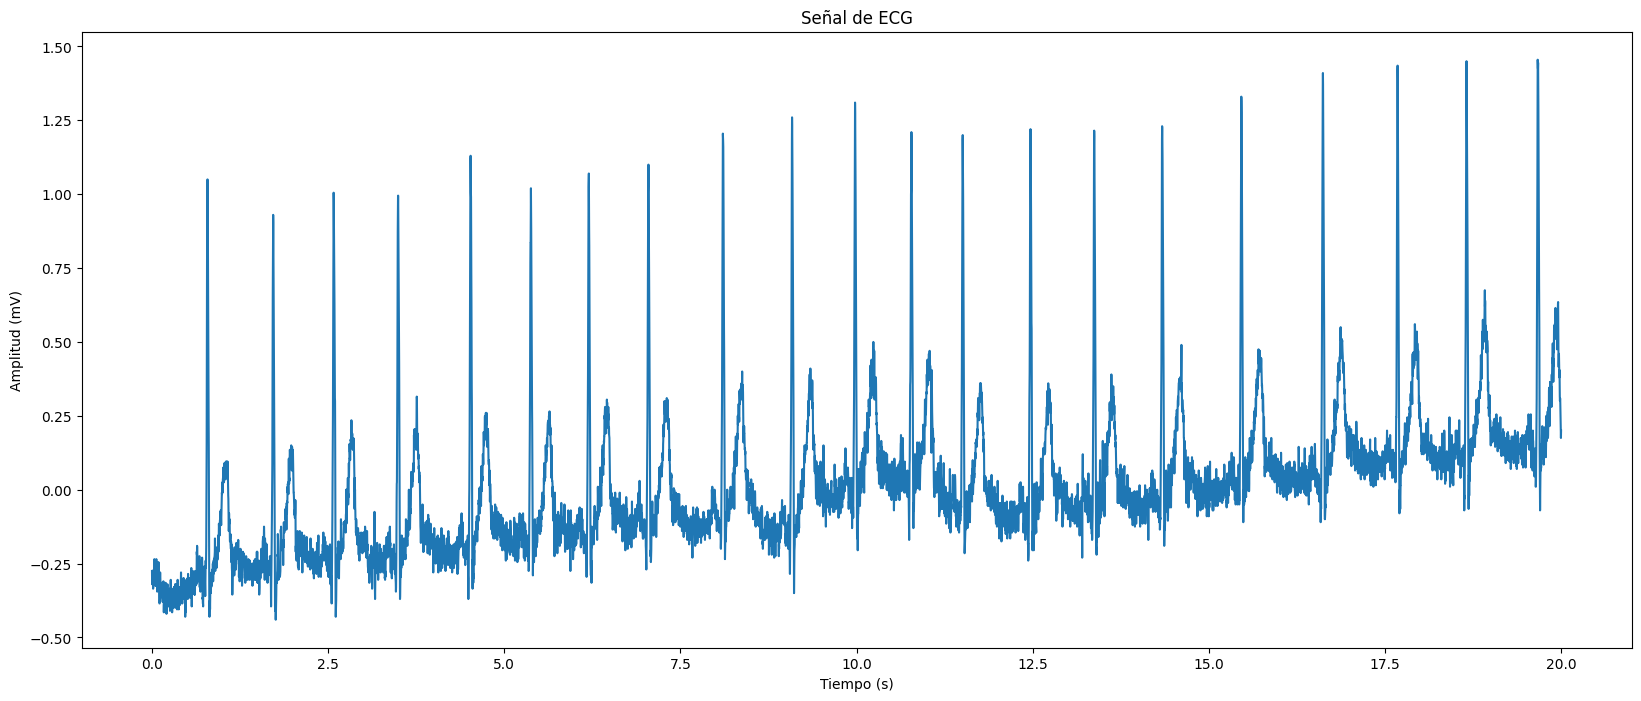

In [377]:
plt.figure(figsize=(20,8))
plt.plot(t, ecg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.title('Señal de ECG')
plt.show()

In [378]:
from scipy.signal import butter, filtfilt
import wfdb.processing as wp
import pywt

class ECGAnalizer:
    def __init__(self):
        pass
    
    @staticmethod
    def equalize_mv(data):
        wavelet = 'bior4.4' # Wavelet biortogonal
        level = 8 # Cantidad de niveles de descomposición de la señal
        coeffs = pywt.wavedec(data, wavelet, level=level)
        coeffs[0] = np.zeros_like(coeffs[0]) # Elimina la menor frecuencia
        ecg_signal_corrected = pywt.waverec(coeffs, wavelet) # Acomoda la señal
        return ecg_signal_corrected
    
    @classmethod
    def filter(cls, data, fs=500, cutoff=10, order=4):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        y = cls.equalize_mv(y)
        return y
    
    @staticmethod
    def p_detect(qrs, sig, unit, frequency=False):
        """
        Detecta ondas P en una señal ECG.
        :param qrs: Lista de posiciones (índices) de los complejos QRS detectados.
        :param sig: Señal de ECG.
        :param sampling_rate: Frecuencia de muestreo de la señal (en Hz).
        :return: Lista de posiciones de las ondas P.
        """
        p_waves = []
        if unit == 'ms':
            window = 300
        else:
            raise ValueError('Unit must be "ms"')

        for qrs_index in qrs:
            p_region = sig[qrs_index-window:qrs_index]

            if len(p_region) > 0:
                peak_index = qrs_index - np.argmax(p_region)  # Encuentra el índice del máximo en la región
                p_waves.append(peak_index)  # Añade el índice global del pico

        return p_waves
    
    @classmethod
    def waves_detect(cls, sig, fs=500, threshold=0.2, unit='ms', obtain_frequency=False):
        qrs = wp.gqrs_detect(sig=sig, fs=fs, threshold=threshold)
        if obtain_frequency:
            frequency = 60/((qrs[1]-qrs[0])/1000)
            print(f"Frequency: {frequency}")
        p = cls.p_detect(qrs, sig, unit)
        return qrs, p
    
    @classmethod
    def obtain_distances(cls, sig):
        """
        Obtiene el intervalo de la señal
        :param sig: señal
        :return: lista de intervalos
        """
        r = []
        for i in range(len(sig)-1):
            r.append(sig[i+1]-sig[i])
        return r
    

In [380]:
ecg_filtrada = ECGAnalizer.filter(ecg, cutoff=2)

print(ecg_filtrada)
qrs_indices, p_indices = ECGAnalizer.waves_detect(sig=ecg_filtrada, threshold=0.5)

[ 0.02083946  0.02023868  0.01963898 ... -0.02871139 -0.02892315
 -0.02911986]


In [372]:
print(qrs_indices)

[]


IndexError: arrays used as indices must be of integer (or boolean) type

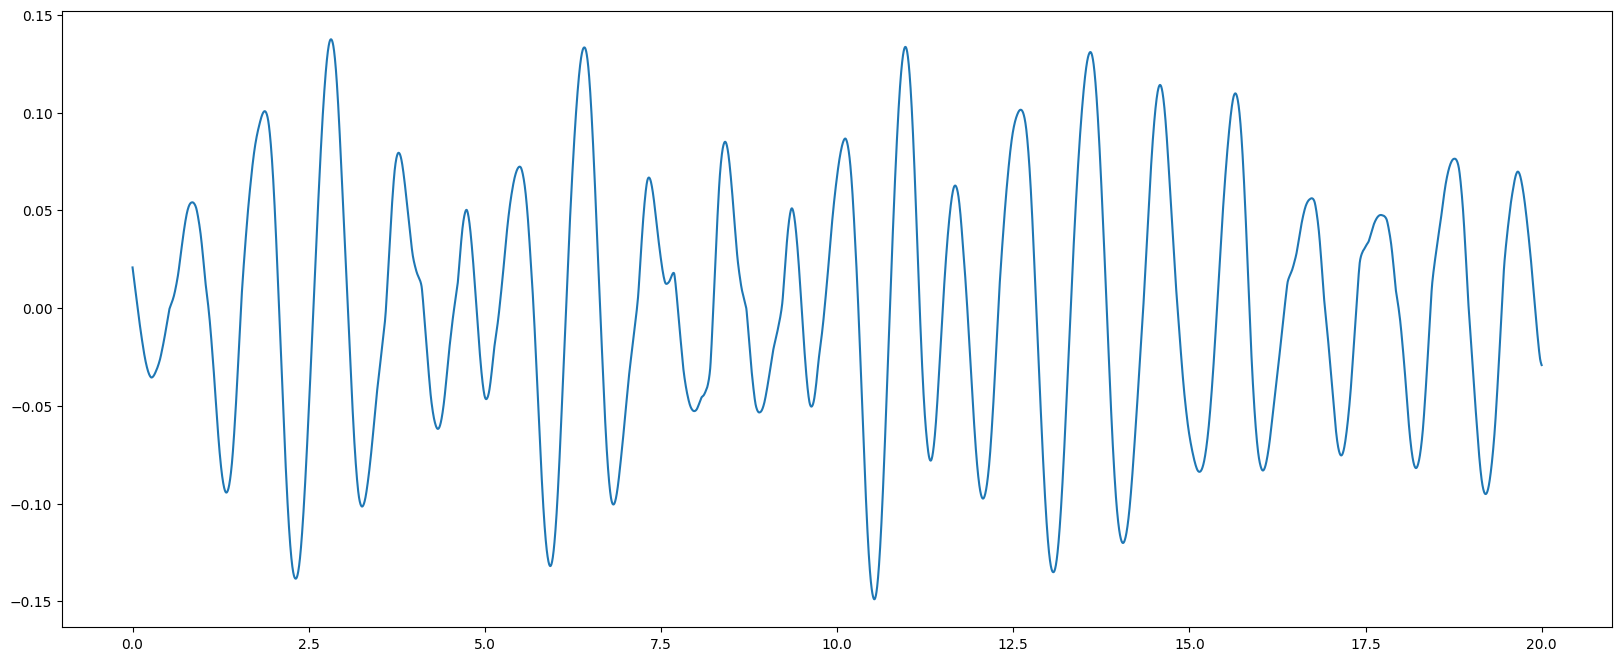

In [373]:
# Graficar picos R
plt.figure(figsize=(20,8))
plt.plot(t, ecg_filtrada)
plt.plot(t[p_indices], ecg_filtrada[p_indices], 'ro')  # Marcar picos
plt.plot(t[qrs_indices], ecg_filtrada[qrs_indices], 'go')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.title('Picos R detectados en la señal de ECG (sin ruido)')
plt.show()


In [362]:
print(qrs_indices)

[]


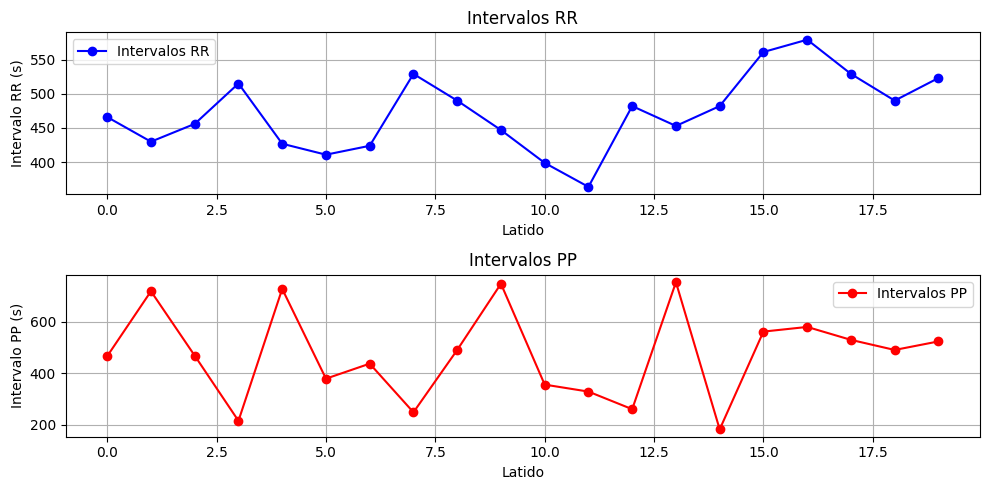

In [268]:
# Extraer intervalos RR
rr_intervals = ECGAnalizer.obtain_distances(qrs_indices)
# Extraer intervalos PP
pp_intervals = ECGAnalizer.obtain_distances(p_indices)

plt.figure(figsize=(10, 5))

# Subplot para los intervalos RR
plt.subplot(2, 1, 1)
plt.plot(rr_intervals, marker='o', label="Intervalos RR", color='b')
plt.title("Intervalos RR")
plt.xlabel("Latido")
plt.ylabel("Intervalo RR (s)")
plt.grid(True)
plt.legend()

# Subplot para los intervalos PP
plt.subplot(2, 1, 2)
plt.plot(pp_intervals, marker='o', label="Intervalos PP", color='r')
plt.title("Intervalos PP")
plt.xlabel("Latido")
plt.ylabel("Intervalo PP (s)")
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

## Obtención masiva de datos

In [235]:
import hashlib

class ECGBiometricDataset:
    def __init__(self):
        pass
    
    @classmethod
    def extract_datasets(cls, n, path, name_of_patient_folder, name_of_files, base_names=None):
        
        data = []
        for i in range(n):
            record = wfdb.rdsamp(f'{path}/{name_of_patient_folder}_{i+1}/{name_of_files}')
            ecg = record[0]
            ecg = np.transpose(ecg)
            ecg = ecg[0]
            info = record[1]['comments']
            if base_names is not None:
                info.append(base_names[i])
            data.append((ecg, info))
            
        df = pd.DataFrame(data, columns=['ecg', 'info'])
        return df
        # Crear filtro pasa bajo
    
    @staticmethod
    def __butter_lowpass_filter(data, cutoff, fs, order=4):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    @staticmethod
    def encode_interval(interval):
        e = ""
        for i in range(len(interval)):
            e += str(round(interval[i], 1))
        # sha256 = hashlib.sha256()
        # sha256.update(e.encode('utf-8'))
        # return sha256.hexdigest()
        return e
        
    @classmethod
    def obtain_pattern_dataset(cls, data, cutoff=10, fs=360, ts=1):
        
        ecgs = data
        
        pattern = []
        
        fs = fs
        ts = ts/fs
        
        for _,row in data.iterrows():
            ecg = row['ecg']
            info = row['info']
            # vector de tiempo
            t = np.linspace(0,np.size(ecg), np.size(ecg))*ts #punto de inicio = 0, punto final = ultimo dato
            # Aplicar filtro
            c = cutoff  # Frecuencia de corte (ajustar según el ruido)
            ecg_filtrada = cls.__butter_lowpass_filter(ecg, c, fs)
            # Detectar picos R usando wfdb
            qrs_indices = wp.gqrs_detect(sig=ecg_filtrada, fs=fs, threshold=0.1)
            # Extraer intervalos RR
            rr_intervals = np.diff(t[qrs_indices])
            encoded_rrintervals = cls.encode_interval(rr_intervals)
            pattern.append((encoded_rrintervals, info))
            
        df = pd.DataFrame(pattern, columns=['rr_intervals', 'info'])
        return df
    
    @staticmethod
    def equals_pattern(pattern, data):
        for _,row in data.iterrows():
            ecg = row['rr_intervals']
            info = row['info']
            
            if ecg == pattern:
                print(info)
            
    
    @classmethod
    def search_pattern(cls, path, data):
        ecg_patient = []  
        record = wfdb.rdsamp(path)
        ecg = record[0]
        ecg = np.transpose(ecg)
        ecg = ecg[0]
        info = record[1]['comments']
        ecg_patient.append((ecg, info))
        df = pd.DataFrame(ecg_patient, columns=['ecg', 'info'])
        
        df_pattern = cls.obtain_pattern_dataset(df)
        cls.equals_pattern(df_pattern['rr_intervals'][0], data)
        


In [236]:
path = './datasets/ecg-id-database-1.0.0/'
name_of_patient_folder = 'Person'
name_of_files = 'rec_1'
base_names = [
    "Juan", "María", "Pedro", "Ana", "Luis", "Laura", "Jorge", "Marta",
    "Carlos", "Sofía", "Andrés", "Isabel", "Francisco", "Patricia",
    "Alejandro", "Lucía", "Diego", "Clara", "Javier", "Gabriela",
    "Fernando", "Valentina", "Eduardo", "Camila", "Santiago", "Daniela",
    "Mateo", "Julieta", "Roberto", "Rosa", "Hugo", "Natalia",
    "Álvaro", "Verónica", "Pablo", "Teresa", "Ricardo", "Ximena",
    "Nicolás", "Adriana", "Emilio", "Luz", "Cristian", "Felipe",
    "Raquel", "Gonzalo", "Cecilia", "Manuel", "Liliana", "Esteban",
    "Alicia", "Mario", "Paloma", "Sergio", "Diana", "Julio",
    "Carmen", "Ramón", "Bárbara", "David", "Emma", "Cristina",
    "Julián", "Victoria", "Bruno", "Milagros", "Salvador", "Florencia",
    "Joaquín", "Marisol", "Guillermo", "Irma", "Samuel", "Verónica",
    "Rafael", "Eva", "Rafael", "Oriana", "Isidro", "Beatriz",
    "Ángela", "Michell", "Héctor", "Rodolfo", "Susana", "Horacio",
    "Luciano", "Mercedes", "Ernesto", "Verón", "Dario"
]
datasets = ECGBiometricDataset.extract_datasets(n=90, path=path, name_of_patient_folder=name_of_patient_folder, name_of_files=name_of_files, base_names=base_names)

In [237]:
datasets

,ecg,info
0,"[-0.085, -0.08, -0.07, -0.075, -0.095, -0.09, ...","[Age: 25, Sex: male, ECG date: 07.12.2004, Juan]"
1,"[-0.215, -0.15, -0.16, -0.195, -0.28, -0.335, ...","[Age: 23, Sex: female, ECG date: 07.12.2004, M..."
2,"[0.335, 0.125, -0.055, 0.06, 0.135, 0.355, 0.5...","[Age: 23, Sex: female, ECG date: 15.03.2005, P..."
3,"[0.055, 0.05, 0.205, 0.27, 0.285, 0.275, 0.165...","[Age: 21, Sex: female, ECG date: 15.03.2005, Ana]"
4,"[-0.38, -0.36, -0.34, -0.26, -0.395, -0.49, -0...","[Age: 21, Sex: male, ECG date: 15.03.2005, Luis]"
...,...,...
85,"[0.025, 0.03, 0.0, 0.005, -0.03, -0.005, -0.12...","[Age: 16, Sex: female, ECG date: 21.05.2005, H..."
86,"[-0.215, -0.18, -0.18, -0.125, -0.12, -0.16, -...","[Age: 16, Sex: female, ECG date: 21.05.2005, L..."
87,"[1.7, 1.75, 2.03, 2.03, 2.155, 2.56, 2.17, 1.6...","[Age: 32, Sex: male, ECG date: 21.05.2005, Mer..."
88,"[-0.46, -0.25, -0.145, -0.04, 0.76, 0.51, -0.1...","[Age: 40, Sex: female, ECG date: 21.05.2005, E..."


In [238]:
datasets_filtered = ECGBiometricDataset.obtain_pattern_dataset(datasets)

In [239]:
datasets_filtered

,rr_intervals,info
0,1.01.11.31.31.31.31.21.21.21.21.11.11.01.01.01...,"[Age: 25, Sex: male, ECG date: 07.12.2004, Juan]"
1,1.21.21.31.21.21.21.11.11.11.21.21.21.11.21.31...,"[Age: 23, Sex: female, ECG date: 07.12.2004, M..."
2,1.11.11.21.21.21.21.11.01.01.01.11.01.11.11.11...,"[Age: 23, Sex: female, ECG date: 15.03.2005, P..."
3,1.31.31.21.21.01.01.11.21.11.21.31.21.11.21.31...,"[Age: 21, Sex: female, ECG date: 15.03.2005, Ana]"
4,1.51.31.61.51.51.61.51.61.71.51.61.71.51.31.71...,"[Age: 21, Sex: male, ECG date: 15.03.2005, Luis]"
...,...,...
85,0.40.40.50.60.90.90.40.50.80.80.40.50.80.80.80...,"[Age: 16, Sex: female, ECG date: 21.05.2005, H..."
86,1.01.01.11.51.31.21.00.90.90.91.01.11.11.11.11...,"[Age: 16, Sex: female, ECG date: 21.05.2005, L..."
87,1.21.21.21.11.11.11.21.21.21.21.21.20.63.00.50...,"[Age: 32, Sex: male, ECG date: 21.05.2005, Mer..."
88,1.31.41.41.31.31.31.31.21.31.31.21.31.31.21.31...,"[Age: 40, Sex: female, ECG date: 21.05.2005, E..."


In [240]:
ECGBiometricDataset.search_pattern('./datasets/ecg-id-database-1.0.0/Person_1/rec_2', datasets_filtered)